Percentage of white pixels:  0.9264


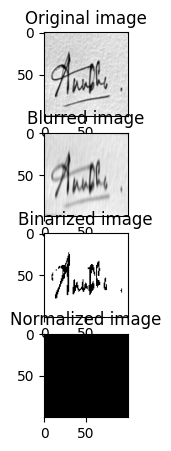

In [59]:
from skimage import img_as_ubyte # type: ignore
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, transform # type: ignore


def process_file(file: str):
    f, ax = plt.subplots(4, figsize=(5, 5))

    img = img_as_ubyte(imread('./signs/' + file, as_gray=True))
    img = img.astype(np.uint8)

    # determine whether image is empty or not
    if np.sum(img) == 0:
        print('Empty image')
        return

    # resize image
    img = transform.resize(img, (100, 100), anti_aliasing=True, preserve_range=True).astype(np.uint8)

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original image')

    blurred = filters.gaussian(img, 2, preserve_range=True, channel_axis=1)
    ax[1].imshow(blurred, cmap='gray')
    ax[1].set_title('Blurred image')

    threshold = filters.threshold_otsu(img)
    binarized_img = blurred > threshold
    ax[2].imshow(binarized_img, cmap='gray')
    ax[2].set_title('Binarized image')

    # calculate the percentage of white pixels
    white_pixels = np.sum(binarized_img)
    total_pixels = binarized_img.shape[0] * binarized_img.shape[1]
    percentage = white_pixels / total_pixels
    print('Percentage of white pixels: ', percentage)

    normalized = np.ones((100, 100), dtype=np.uint8) * 255
    normalized[normalized > threshold] = 255
    ax[3].imshow(normalized, cmap='gray')
    ax[3].set_title('Normalized image')

import os

process_file(os.listdir('./signs/')[2])
# for file in os.listdir('./signs/'):
#     process_file(file)
#     break

In [64]:
import numpy as np
from skimage import filters, transform # type: ignore
from typing import Tuple


def preprocess_signature(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    """ Pre-process a signature image, centering it in a canvas, resizing the image and cropping it.

    Parameters
    ----------
    img : np.ndarray (H x W)
        The signature image
    canvas_size : tuple (H x W)
        The size of a canvas where the signature will be centered on.
        Should be larger than the signature.
    img_size : tuple (H x W)
        The size that will be used to resize (rescale) the signature
    input_size : tuple (H x W)
        The final size of the signature, obtained by croping the center of image.
        This is necessary in cases where data-augmentation is used, and the input
        to the neural network needs to have a slightly smaller size.

    Returns
    -------
    np.narray (input_size):
        The pre-processed image
    -------

    """
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped


def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:
    """ Centers an image in a pre-defined canvas size, and remove
    noise using OTSU's method.

    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be processed
    canvas_size : tuple (H x W)
        The desired canvas size

    Returns
    -------
    np.ndarray (H x W)
        The normalized image
    """

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)
    print('threshold: ', threshold)

    # set threshold to 0.5
    # threshold = 0.5

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255
    return normalized_image



def remove_background(img: np.ndarray) -> np.ndarray:
        """ Remove noise using OTSU's method.

        Parameters
        ----------
        img : np.ndarray
            The image to be processed

        Returns
        -------
        np.ndarray
            The image with background removed
        """

        img = img.astype(np.uint8)
        # Binarize the image using OTSU's algorithm. This is used to find the center
        # of mass of the image, and find the threshold to remove background noise
        threshold = filters.threshold_otsu(img)

        # Remove noise - anything higher than the threshold. Note that the image is still grayscale
        img[img > threshold] = 255

        return img


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    """ Crops an image to the desired size without stretching it.

    Parameters
    ----------
    img : np.ndarray (H x W)
        The image to be cropped
    size : tuple (H x W)
        The desired size

    Returns
    -------
    np.ndarray
        The cropped image
    """
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image

        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size

        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped


def crop_center_multiple(imgs: np.ndarray,
                         size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of multiple images

        Parameters
        ----------
        imgs : np.ndarray (N x C x H_old x W_old)
            The images to be cropped
        size: tuple (H x W)
            The desired size

        Returns
        -------
        np.ndarray (N x C x H x W)
            The cropped images
        """
    img_shape = imgs.shape[2:]
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = imgs[:, :, start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped




threshold:  168
327167644


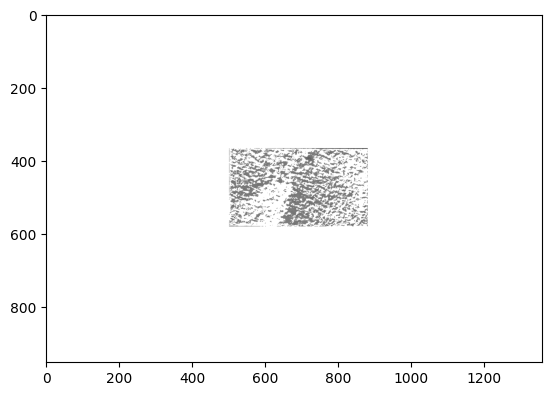

In [67]:
canvas_size = (952, 1360)
im1 = normalize_image(img_as_ubyte(imread('./signs/eg_0856_3994.png', as_gray=True)).astype(np.uint8), canvas_size)
# im1 = normalize_image(img_as_ubyte(imread('./signs/eg_1241_8981.png', as_gray=True)).astype(np.uint8), canvas_size)
plt.imshow(im1, cmap='gray')
print(np.sum(im1))

./signs/eg_0023_7833.png 0.2175
./signs/eg_0034_4827.png 0.0
./signs/eg_0082_7073.png 0.0
./signs/eg_0230_0947.png 0.165
./signs/eg_0285_4322.png 0.14
./signs/eg_0288_5784.png 0.0
./signs/eg_0305_3474.png 0.325
./signs/eg_0384_1840.png 0.215
./signs/eg_0436_2170.png 0.0
./signs/eg_0525_8786.png 0.345
./signs/eg_0565_0628.png 0.0
./signs/eg_0633_1529.png 0.28
./signs/eg_0668_9790.png 0.35
./signs/eg_0732_4836.png 0.0
./signs/eg_0856_3994.png 0.0
./signs/eg_0877_2491.png 0.2
./signs/eg_0925_7731.png 0.0
./signs/eg_1023_6736.png 0.2625
./signs/eg_1073_0159.png 0.26
./signs/eg_1100_4648.png 0.0
./signs/eg_1120_5213.png 0.315
./signs/eg_1157_6727.png 0.1875
./signs/eg_1202_5135.png 0.0
./signs/eg_1241_8981.png 0.2775
./signs/eg_1281_5578.png 0.0
./signs/eg_1317_2347.png 0.3325
./signs/eg_1368_8490.png 0.1675
./signs/eg_1387_9160.png 0.3325
./signs/eg_1537_0402.png 0.0
./signs/eg_1609_4513.png 0.2925
./signs/eg_1674_5855.png 0.0
./signs/eg_1688_8771.png 0.18
./signs/eg_1708_6499.png 0.245
./

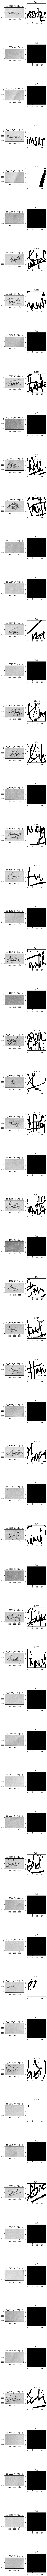

In [116]:
import cv2

def fn(file):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (50, 50))
    # img = cv2.GaussianBlur(img, (5, 5), 0)
    # img = cv2.medianBlur(img, 5)

    # remove 20px from each side but keeping the same center
    img = img[15:35, 15:35]

    img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21) # type: ignore
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


    # dilate image
    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # img = cv2.dilate(img, kernel, iterations=1)

    # binarize image
    # _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # threshold = 0.5 * 255
    # img[img > threshold] = 255
    # img[img <= threshold] = 0


    # remove 10px from each side
    # img = img[10:40, 10:40]

    # calculate black pixel percentage
    black = np.count_nonzero(img == 0)
    white = np.count_nonzero(img == 255)
    total = black + white
    black_percentage = black / total
    print(file, black_percentage)

    return (img, black_percentage)

# img1 = cv2.imread('./signs/eg_0856_3994.png', cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread('./signs/eg_1241_8981.png', cv2.IMREAD_GRAYSCALE)

ROWS = 63

f, ax = plt.subplots(ROWS, 2, figsize=(5, 5 * ROWS))

for idx, file in enumerate(os.listdir('./signs')):
    if idx < ROWS:
        ax[idx][0].imshow(cv2.imread('./signs/' + file, cv2.IMREAD_GRAYSCALE), cmap='gray')
        ax[idx][0].set_title(file)

        (img, blk) = fn('./signs/' + file)
        ax[idx][1].imshow(img, cmap='gray')
        ax[idx][1].set_title(str(blk))

# ax[0].imshow(fn('./signs/eg_0856_3994.png'), cmap='gray')
# ax[1].imshow(fn('./signs/eg_1241_8981.png'), cmap='gray')
# ax[2].imshow(fn('./signs/eg_3522_0008.png'), cmap='gray')
